# LAB 03.02 - Timeseries model

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/fagonzalezo/ai4eng-unal/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()


In [ ]:
from local.lib.rlxmoocapi import submit, session
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L03.02", varname="student");

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from local.lib import timeseries as ts
import pandas as pd
import os
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

## A synthetic timeseries

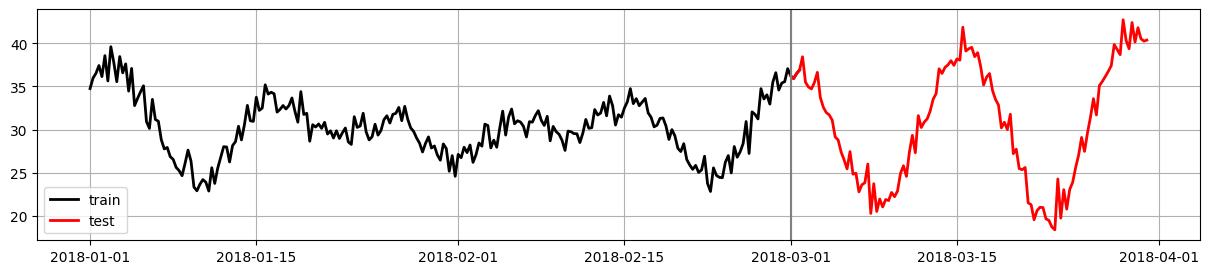

In [4]:

date_split = "2018-03-01"

idx = pd.date_range("2018-01-01", "2018-03-31", freq="6h")
i = np.linspace(-5,4,len(idx))
i = np.linspace(np.random.random()*5-5,np.random.random()*5+2,len(idx))
t = np.log(i**2+.3)*np.cos(4*i)
t += (np.random.normal(size=len(idx))*.4)
t = np.round(t*3+30,3)
d = pd.DataFrame(np.r_[[t]].T, columns=["signal"], index=idx) 
d.index.name="date"

plt.figure(figsize=(15,3))
plt.plot(d[:date_split].index, d[:date_split].signal, color="black", lw="2", label="train"); 
plt.plot(d[date_split:].index, d[date_split:].signal, color="red", lw="2", label="test"); 
plt.axvline(date_split, color="grey"); plt.legend();plt.grid();
signal = d


In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 357 entries, 2018-01-01 00:00:00 to 2018-03-31 00:00:00
Freq: 6h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   signal  357 non-null    float64
dtypes: float64(1)
memory usage: 13.7 KB


In [6]:
d.head(10)

signal
date                       
2018-01-01 00:00:00  34.751
2018-01-01 06:00:00  35.968
2018-01-01 12:00:00  36.531
2018-01-01 18:00:00  37.424
2018-01-02 00:00:00  36.141
2018-01-02 06:00:00  38.576
2018-01-02 12:00:00  35.640
2018-01-02 18:00:00  39.608
2018-01-03 00:00:00  37.777
2018-01-03 06:00:00  35.547

## Task 1. Build a time series training dataset

In this task, starting off from the time signal above, you must build an **annotated dataset** so that at any time instant **given the three last `n_timesteps_lookback` signal values and the current one** we want to **predict the next one**.

Complete the following function so that when receiving a time indexed dataframe such as the one above, the resulting dataframe is such that:

- the column **signal** is left untouched
- there are `n_timesteps_lookback`+1 new columns:
    - the column **signal+1** contains the signal one time step into the future
    - the columns **signal-1**, **signal-2**, etc. contain the signal one, two, etc. time steps into the past.

- the resulting dataset contains (`n_timesteps_lookback`+1) rows less than the original dataset, one due to the **signal+1** column and the rest for the **signal-x** columns. For instance, if the original dataset contained 357 rows, with `n_timesteps_lookback=3` the resulting dataframe will contain 353 rows.

**Hint**: use [`pandas.DataFrame.join`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html), [`pandas.DataFrame.shift`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) and [`pandas.DataFrame.dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

For instance, with this input

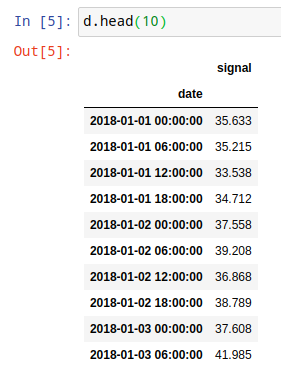

In [7]:
Image("local/imgs/df_tseries1.png")

you should produce the following output

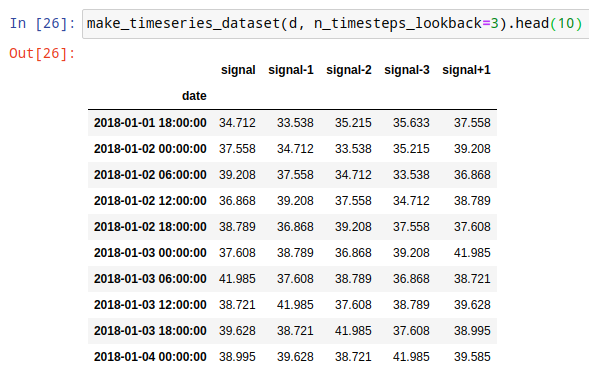

In [8]:
Image("local/imgs/df_tseries2.png")

In [9]:
def make_timeseries_dataset(signal, n_timesteps_lookback):
    import pandas as pd
    r = signal.copy()
    for i in range(1, n_timesteps_lookback+1):
        r[f'signal-{i}'] = r['signal'].shift(i)
    r['signal+1'] = r['signal'].shift(-1)
    return r.dropna()

test your code

In [10]:
make_timeseries_dataset(d, n_timesteps_lookback=3).head(10)

signal  signal-1  signal-2  signal-3  signal+1
date                                                               
2018-01-01 18:00:00  37.424    36.531    35.968    34.751    36.141
2018-01-02 00:00:00  36.141    37.424    36.531    35.968    38.576
2018-01-02 06:00:00  38.576    36.141    37.424    36.531    35.640
2018-01-02 12:00:00  35.640    38.576    36.141    37.424    39.608
2018-01-02 18:00:00  39.608    35.640    38.576    36.141    37.777
2018-01-03 00:00:00  37.777    39.608    35.640    38.576    35.547
2018-01-03 06:00:00  35.547    37.777    39.608    35.640    38.467
2018-01-03 12:00:00  38.467    35.547    37.777    39.608    36.575
2018-01-03 18:00:00  36.575    38.467    35.547    37.777    37.615
2018-01-04 00:00:00  37.615    36.575    38.467    35.547    34.460

**submit your answer**

In [11]:
student.submit_task(globals(), task_id="task_01");

## Task 2. Manually apply a regression model to create predictions

Complete the following function to apply the a linear regression model to a dataframe such as the resulting one from the previous task:

$$\hat{y} = w_0 + w_1s + w_2s_{-1} + w_3s_{-2} + w_4s_{-3} ... $$

where $s$ corresponds to the column named `signal`, $s_{-1}$ to the column named `signal-1`, etc.

Observe that:

- column `signal+1` is not used, as it is the expected prediction. You will use it in the next task.
- you will have `n_timesteps_lookback`+2 $w$ parameters, since you will have one per each `n_timesteps_lookback`, plus $w_0$, plus $w_1$

Expect the function arguments as follow:

- `td`: a Pandas dataframe such as the output of the function `make_timeseries_dataset` of the previous task, with exactly the same column names
- `w`: a Numpy array with `n_timesteps_lookback`+2 elements in the order $[w_0, w_1, ...]$

**Warn**:  the DataFrame `td` may contain any number of lookback columns and might be in **any order**

**Challenge**: solve it with one single line of Python code

**EXAMPLE**: For the following dataframe and $w$

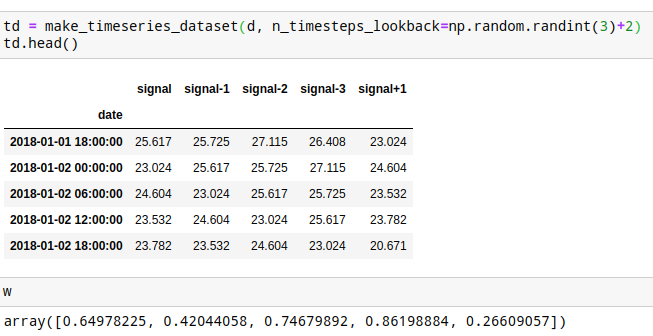

In [12]:
Image("local/imgs/ts_reg_1.png")

you should get the following results

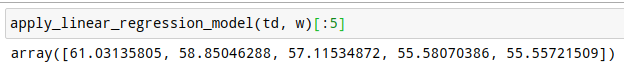

In [13]:
Image("local/imgs/ts_reg_2.png")

In [14]:
def apply_linear_regression_model(td, w):
    r = td.drop(columns=['signal+1']).sort_index(axis=1).values @ w[1:] + w[0]
    return r

### test your code manually

observe how we permute the columns order

In [15]:
td = make_timeseries_dataset(d, n_timesteps_lookback=np.random.randint(3)+2)
td = td[np.random.permutation(td.columns)]
td.head()

signal  signal-2  signal+1  signal-1
date                                                     
2018-01-01 12:00:00  36.531    34.751    37.424    35.968
2018-01-01 18:00:00  37.424    35.968    36.141    36.531
2018-01-02 00:00:00  36.141    36.531    38.576    37.424
2018-01-02 06:00:00  38.576    37.424    35.640    36.141
2018-01-02 12:00:00  35.640    36.141    39.608    38.576

In [16]:
w = np.random.random(len(td.columns))
w

array([0.56164519, 0.61761901, 0.05441944, 0.40238289])

In [17]:
apply_linear_regression_model(td[np.random.permutation(td.columns)], w)[:5]

array([39.06445138, 40.13632328, 39.61905621, 41.41246629, 39.21539094])

**submit your answer**

In [18]:
student.submit_task(globals(), task_id="task_02");

## Task 3: Measure trend prediction

You will now use the predictions to measure **trend accuracy**. We will compare any predictions which are given to us with the actual next value in column **signal+1** in the following way

- if **signal+1>signal** and ALSO your **prediction>signal**, then your model has a **correct trend prediction** regardless how different are **signal+1** and **prediction**
- if **signal+1<=signal** and ALSO your **prediction<=signal**, then your model has a **correct trend prediction** regardless how different are **signal+1** and **prediction**
- otherwise, your model has an **incorrect prediction**

Complete the following function such that when receiving a dataframe such as the resulting one from task 1 above, and a `pd.Series` with the same index and price predictions, computes the accuracy of the predictions (the percentage of correct predictions).

The accuracy must be a `float` and its correctness will be checked up to 2 decimal places.

**Challenge**: solve it with one single line of Python code.

**EXAMPLE**: for the following time series dataset

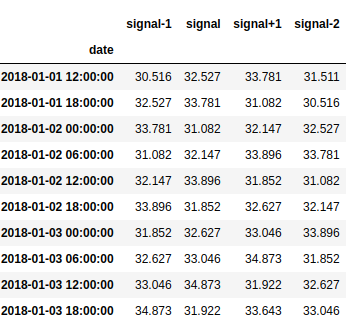

In [19]:
Image("local/imgs/ts_reg_3.png")

And the following predictions

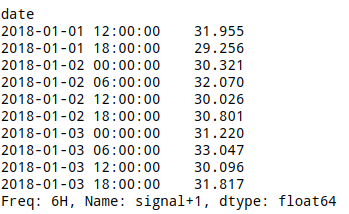

In [20]:
Image("local/imgs/ts_reg_4.png")

The trend accuracy is `0.4` since the trend is correctly hit by the predictions on rows 1, 4, 7 and 8 (assuming the first row is numbered as 0)

In [21]:
def measure_trend_accuracy(td, preds):
    r = ((td['signal+1'] > td['signal']).astype(int) == (preds > td['signal']).astype(int)).mean()
    return r

### test your code manually


In [22]:
td = make_timeseries_dataset(d, n_timesteps_lookback=np.random.randint(3)+2).iloc[:10]
td

signal  signal-1  signal-2  signal+1
date                                                     
2018-01-01 12:00:00  36.531    35.968    34.751    37.424
2018-01-01 18:00:00  37.424    36.531    35.968    36.141
2018-01-02 00:00:00  36.141    37.424    36.531    38.576
2018-01-02 06:00:00  38.576    36.141    37.424    35.640
2018-01-02 12:00:00  35.640    38.576    36.141    39.608
2018-01-02 18:00:00  39.608    35.640    38.576    37.777
2018-01-03 00:00:00  37.777    39.608    35.640    35.547
2018-01-03 06:00:00  35.547    37.777    39.608    38.467
2018-01-03 12:00:00  38.467    35.547    37.777    36.575
2018-01-03 18:00:00  36.575    38.467    35.547    37.615

In [23]:
preds = td['signal'] + np.round(np.random.random()*4-2,3)
preds

date
2018-01-01 12:00:00    36.352
2018-01-01 18:00:00    37.245
2018-01-02 00:00:00    35.962
2018-01-02 06:00:00    38.397
2018-01-02 12:00:00    35.461
2018-01-02 18:00:00    39.429
2018-01-03 00:00:00    37.598
2018-01-03 06:00:00    35.368
2018-01-03 12:00:00    38.288
2018-01-03 18:00:00    36.396
Freq: 6h, Name: signal, dtype: float64

In [24]:
measure_trend_accuracy(td, preds)

0.5

**submit your answer**

In [25]:
student.submit_task(globals(), task_id="task_03");